I very rarely see any sort of inspection being done on the convolutional kernels of a CNN. In part this is because the parameters themselves are far more difficult to interpret than the outputs of a network (even intermediate outputs a.k.a the network activations). This difficulty of interpretation is worst for kernels with a small spatial footprint and unfortunately 3x3 kernels are the most performant and popular choice. Trying to understand the structure of a 3x3 convolution kernel by looking at all of the possible 3x3 spatial slices is somewhat like trying to guess what an full image looks like from being shown all the 3x3 chunks of it in random order. 

Despite the difficulties I think good kernel visualizations are a worthwile pursuit. Good visualization techniques can be powerful diagnostics and the better the visualizations of our models the more powerful and robust we can make them. As a motivational carrot here is a teaser plot of a visualization of a simple network which we generate in this post.

![teaser_plot](../images/visualizing_convolution_kernels_teaser.png)

<!-- TEASER_END -->

Work on visualizing neural networks has mostly dealt with how to visualize the activations within the network when we pass in test images (or at least the work I am familiar with). Two common approaches are to either look at heat maps of the activations of particular layers/channels, or to look directly at the images which induce large magnitude activations in those same layers/channels. A particularly nice tool called <a href=https://github.com/tensorflow/lucid>lucid</a> is particularly good for making visualizations of the second sort. 

In this post I don't seek to visualize activations resulting from a set of parameters per-se (though that is helpful). My main goal is to directly visualize the parameter values of the network themselves. To put this distinction in a familiar context consider a simple linear model $y=Ax$. The values in the transform matrix A are the parameters of the model, the values $y$ are the output "activations" of the model and the vector $x$ is the input example. The technique of visualizing the activations of a neural network is analogous to plotting the $y$ resulting from a given $x$. The technique of finding input examples which maximize layer activations is analogous to plotting up the eigenvector of $A$ of maximum magnitude eigenvalue. Attempting to directly visualize the convolution kernel parameters would be analogous to plotting up the rows of $A$. All of these are very useful and complementary tools for understanding a linear model. Of course the analogy is somewhat imperfect since neural networks can be very non-linear but I think the point is valid. Most analysts wouldn't want to give up the freedom to inspect the coefficients of a linear model so why should we give up on inspecting the parameters of a neural network simply because they are harder to interpret?

In [1]:
import numpy as np
np.random.seed(789456)
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
import keras.preprocessing.image
import keras.backend as K

Using TensorFlow backend.


In [2]:
%matplotlib inline
plt.rcParams.update(
    {
        "figure.figsize":(12, 6),
        "font.size":14,
    }
)

# An Example Network

A post about visualizations would be a sad post indeed if we didn't actually visualize anything in it. Lets train a small neural network for predicting the labels on the cifar-10 dataset to play around with.

In [3]:
#load the data
from keras.datasets import cifar10 as dset

(x_train, y_train), (x_test, y_test) = dset.load_data()

#normalize to lie in -1 to 1
x_train = (x_train-127.5)/128
x_test = (x_test-127.5)/128

y_train = y_train.squeeze()
y_test = y_test.squeeze()

n_categories = len(np.unique(y_train))

y_train_onehot = keras.utils.to_categorical(y_train, n_categories)
y_test_onehot = keras.utils.to_categorical(y_test, n_categories)

from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense

def make_net():
    input_img = keras.layers.Input(x_train.shape[1:])
    
    x = input_img
    x = keras.layers.GaussianNoise(0.5/128.0)(x)
    
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)

    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    
    x = keras.layers.GlobalMaxPooling2D()(x)
    
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.3)(x)
    probs = Dense(10, activation="softmax")(x)

    model = keras.models.Model(input_img, probs)
    
    return model

model = make_net()
model.compile(loss="categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])


In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
__________

Lets save the kernel parameters for later analysis.

In [5]:
initial_conv_kernels = [K.get_value(l.kernel) for l in model.layers if isinstance(l, keras.layers.Conv2D)]

In [6]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    height_shift_range=0.1, 
    width_shift_range=0.1,
    fill_mode="reflect"
)

model.fit_generator(
    datagen.flow(x_train, y_train_onehot, batch_size=64), 
    validation_data=(x_test, y_test_onehot), 
    epochs=25,
)

Epoch 1/25
782/782 [==============================] - 13s 16ms/step - loss: 1.7859 - acc: 0.3407 - val_loss: 1.4695 - val_acc: 0.4625
Epoch 2/25
782/782 [==============================] - 12s 16ms/step - loss: 1.3757 - acc: 0.5011 - val_loss: 1.1686 - val_acc: 0.5847
Epoch 3/25
782/782 [==============================] - 12s 16ms/step - loss: 1.1968 - acc: 0.5750 - val_loss: 1.0802 - val_acc: 0.6224
Epoch 4/25
782/782 [==============================] - 12s 15ms/step - loss: 1.0674 - acc: 0.6214 - val_loss: 0.9352 - val_acc: 0.6674
Epoch 5/25
782/782 [==============================] - 12s 15ms/step - loss: 0.9723 - acc: 0.6576 - val_loss: 0.8558 - val_acc: 0.6988
Epoch 6/25
782/782 [==============================] - 12s 16ms/step - loss: 0.9028 - acc: 0.6832 - val_loss: 0.8233 - val_acc: 0.7066
Epoch 7/25
782/782 [==============================] - 12s 16ms/step - loss: 0.8376 - acc: 0.7057 - val_loss: 0.7455 - val_acc: 0.7383
Epoch 8/25
782/782 [==============================] - 12s 15ms

# Stacked Heatmaps

It seems to me that everyone's first impulse when asked to think of a way to visualize a convolution kernel is simply to plot 2D slices of it as heatmaps. Using this technique we can visualize the values in the entire 4D tensor by making one such heatmap for each possible slice through the remaining 2 dimensions. This is a very limted visualization strategy since it makes interpreting the cross channel information very difficult but its straight forward and intuitive nature makes up for its failings.

Negative entries in the convolution kernel are qualitatively different than positive entries and so it is a good idea to use a divergent color map centered on zero for the heatmaps. I'm particularly fond of using a blue-black-orange divergent color map.

In [7]:
from matplotlib.colors import LinearSegmentedColormap

clist = [(0.1, 0.6, 1.0), (0.05, 0.05, 0.05), (0.8, 0.5, 0.1)]
bbo = LinearSegmentedColormap.from_list("custom", clist)

def restack_kernel(kernel, separator_width=0, separator_value=0.0):
    #split the tensor into 2D slices and then restack them
    stack = []
    
    n1, n2, n3, n4 = kernel.shape
    for i in range(n3):
        cur_slices = []
        for j in range(n4):
            cur_slices.append(kernel[:, :, i, j])
            if j != n4-1 and separator_width > 0:
                #add in a vertical separator image
                cur_slices.append(np.repeat(separator_value, n1).reshape((-1, 1)))
        row_stack = np.hstack(cur_slices)
        stack.append(row_stack)
        if i != n3-1 and separator_width > 0:
            #add a horizontal separator
            stack.append(np.repeat(separator_value, row_stack.shape[1]).reshape((1, -1)))
    
    stacked = np.vstack(stack)
    return stacked
    
def stacked_heatmaps_kernel_plot(
    kernel, 
    axis_ordering=None,
    clip_percentile=99.5,
    separator_width=1,
    separator_value=0.0,
    cmap=None,
    ax=None,
    imshow_kwargs=None,
):
    #optionally reorder the axes 
    if not axis_ordering is None:
        kernel = kernel.transpose(axis_ordering)
    
    if cmap is None:
        cmap = bbo
    
    if ax is None:
        fig, ax = plt.subplots()
        
    if imshow_kwargs is None:
        imshow_kwargs = {}
    
    stacked = restack_kernel(kernel, separator_width=separator_width, separator_value=separator_value)
    
    clip_mag = np.percentile(np.abs(stacked), clip_percentile)
    
    im = ax.imshow(stacked, cmap=cmap, vmin=-clip_mag, vmax=clip_mag, **imshow_kwargs)
    return im

In [9]:
conv_kernels = [K.get_value(l.kernel) for l in model.layers if isinstance(l, keras.layers.Conv2D)]

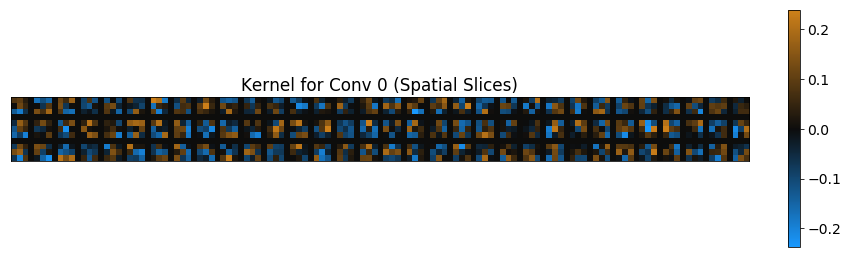

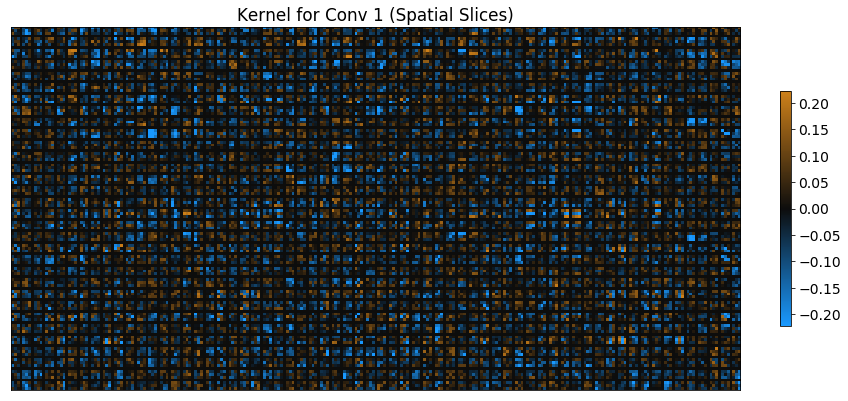

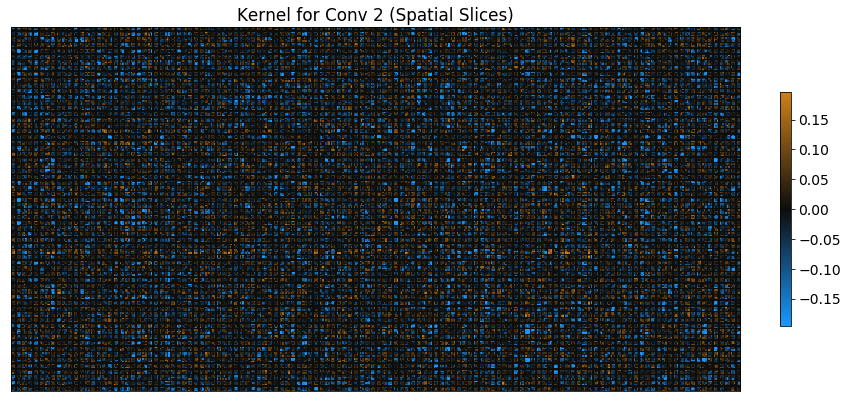

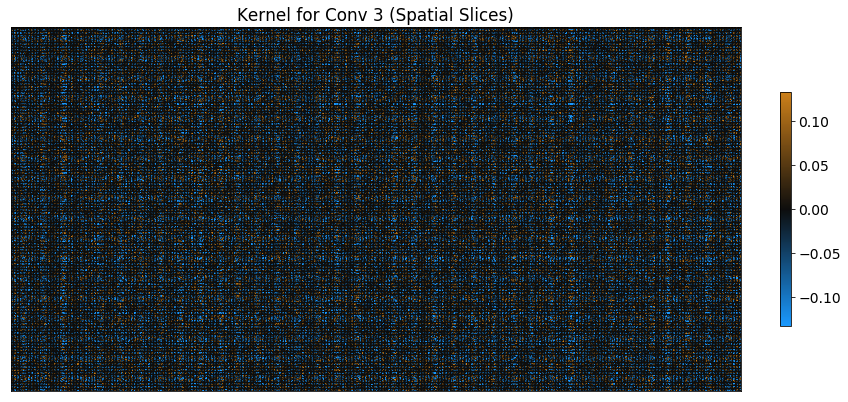

In [115]:
for conv_index, kernel in enumerate(conv_kernels):
    figsize=(12, 6)
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title("Kernel for Conv {} (Spatial Slices)".format(conv_index))
    im = stacked_heatmaps_kernel_plot(kernel, ax=ax)
    plt.colorbar(im, fraction=0.015)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.tight_layout()
    if conv_index == 1:
        #save the second image out as the teaser image for this post
        fig.savefig("../images/visualizing_convolution_kernels_teaser.png")
    plt.show()

These visualizations are certainly fun to look at but gleaning meaningful information from them is difficult. Especially as we move deeper in to the network the visualization comes to look more and more like random noise. There is no meaningful sense of adjacency for input or output channels. The fact that the channel of index 0 is next to the channel at index 1 is pure coincidence. Any random permutation of input or output channels would be just as valid. So although the adjacency in each displayed 3x3 slice is meaningful the larger scale structure is not. 

As we move deeper into the network the important information becomes more and more shifted towards the channel dimensions instead of the spatial dimensions and there is more and more information in the values of the kernels. The visualization above doesn't give much of a sense for how fundamentally different in scale and in type the sort of information present in the small initial kernels versus the later large kernels really is. Because we are rescaling each image to the same figure size we get to clearly see all the details for the first kernel and we at least assign around 1 pixel per parameter value for most of the kernels. But the last layer isn't able to be properly embedded in such a small image at 300 dpi (the matplotlib default). The apparent checkerboard effect you can see in the image for conv3 above is just an aliasing artifact, not actually a true structural effect.

We can fix the aliasing problem and give a sense for the true relative sizes of the kernels by scaling each image size to be proportional to the number of input/output channels in each (plus a term for kernel width and height). Lets also get rid of the colorbar and turn the matplotlib title into a print statement so that they don't mess with the relative scaling of the axes. This way each parameter value gets roughly the same amount of screen real estate no matter which layer it belongs to.

Kernel for Conv 0
figure size [ 2.      0.1875] inches


Kernel for Conv 1
figure size [ 4.  2.] inches


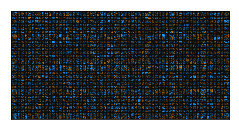

Kernel for Conv 2
figure size [ 8.  4.] inches


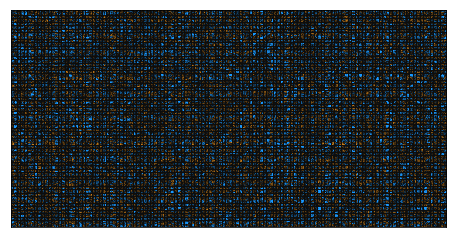

Kernel for Conv 3
figure size [ 16.   8.] inches


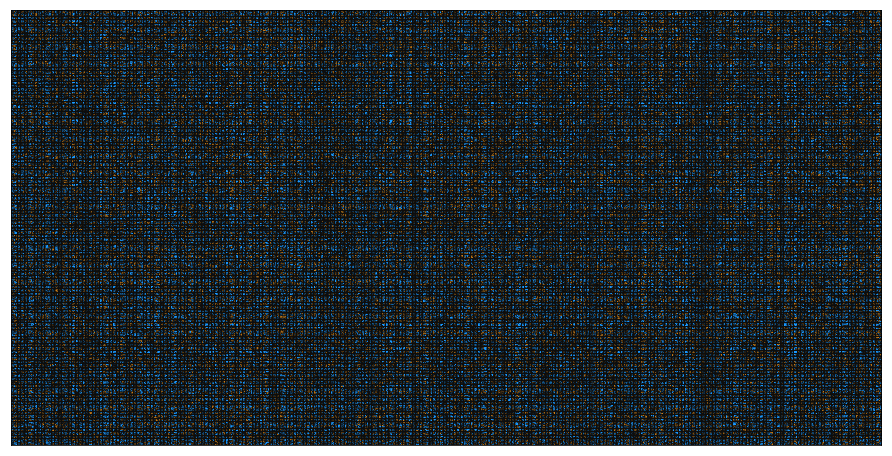

In [11]:
for conv_index, kernel in enumerate(conv_kernels):
    figsize = np.array([max(0.1, kernel.shape[1]*kernel.shape[3]/48), max(0.1, kernel.shape[0]*kernel.shape[2]/48)])
    print("Kernel for Conv {}".format(conv_index))
    print("figure size", figsize, "inches")
    fig, ax = plt.subplots(figsize=figsize)
    im = stacked_heatmaps_kernel_plot(kernel, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

Looking at these last set of visualizations I think nicely illustrates the sheer scale of the problem. A simple grid of heatmaps works mildly well for visualizing the input layer of a network or even the first few layers, just as long as the number of input/output channels is relatively small. But for deeper network layers there is just too much information stored in the channelwise dimensions of the kernels to make this a really effective strategy. 

# Playing Games with Parameter Ordering

Because we are choosing to preserve the adjacency of the pixels along the spatial dimensions in the above visualizations we are giving quite a lot of emphasis to the spatial structure of the kernels. As the spatial kernel structure becomes more and more dilute relative to the cross channel structure of the kernels of course the visualizations become less understandable. 

We can try to emphasize the channel information instead by picking slices through the kernel along the input and output channel axes instead of the spatial axes and then stacking these slices by pixel order. 

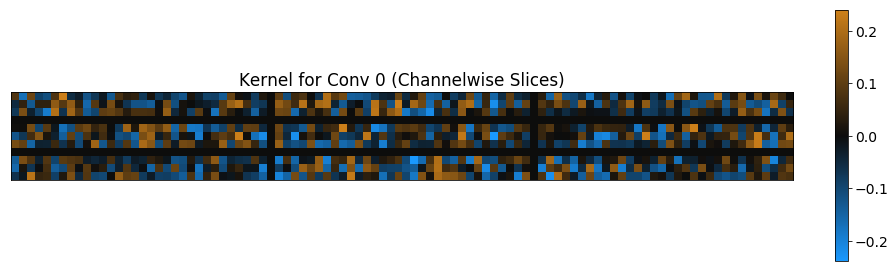

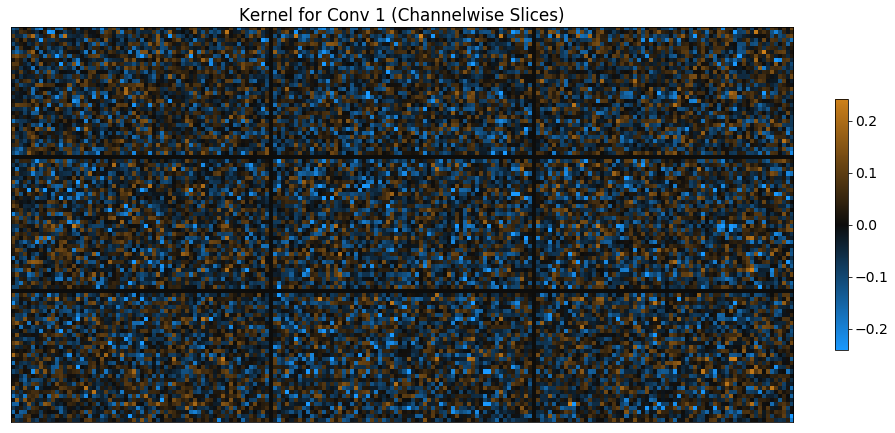

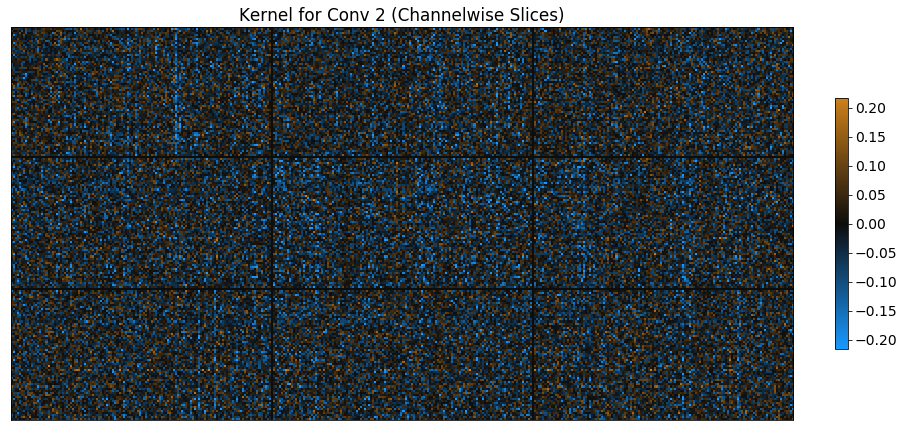

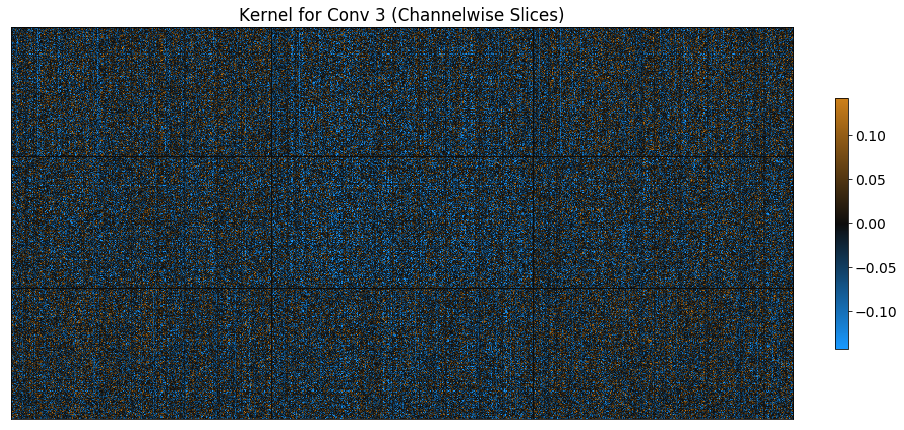

In [12]:
for conv_index, kernel in enumerate(conv_kernels):
    figsize=(15, 10)
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title("Kernel for Conv {} (Channelwise Slices)".format(conv_index))
    im = stacked_heatmaps_kernel_plot(kernel, axis_ordering=[2, 3, 0, 1], ax=ax)
    plt.colorbar(im, fraction=0.015)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

Since the channel ordering is effectively random it should be no real surprise that the effect of preserving the meaningless channel adjacency at the price of the spatial adjacency results in something much more chaotic looking than before.

There is likely no "correct" way to pick a channel ordering but anything is better than completely random right? Well I am not going to junk up the post with images of all the different things I tried. I tried agglomerative clustering like in my post about visualizing correlation heatmaps, I tried ordering by variance of the kernels over input and output channels, I tried ordering by central magnitude, I tried ordering by mean magnitude, I tried ordering by mean value, I tried ordering by a specialized heuristic search to find the best chain of rows which look something like a progressive sequence. All of these attempts resulted in things which looked essentially like random garbage. The progressive sequence search seemed most promising but the implementation is problematic and potentially buggy, it may turn into a post of its own in the future.

But for the current task of making good visualizations of convolution kernels I think the moral is clear. Without the context which the network activations, data, and parameters provide the values in the kernels just look essentially like the random noise.

In fact...

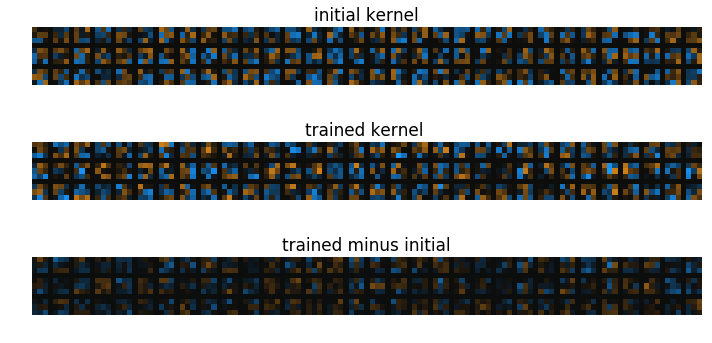

In [33]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6))

k0_initial = restack_kernel(initial_conv_kernels[0], separator_width=1)
k0_trained = restack_kernel(conv_kernels[0], separator_width=1)

k0_initial_normed = (k0_initial-np.mean(initial_conv_kernels[0]))/np.std(initial_conv_kernels[0])
k0_trained_normed = (k0_trained-np.mean(conv_kernels[0]))/np.std(conv_kernels[0])

vmax = max(np.percentile(np.abs(k0_trained_normed), 99.5), np.percentile(k0_initial_normed, 99.5))

axes[0].imshow(k0_initial_normed, vmin=-vmax, vmax=vmax, cmap=bbo)
axes[1].imshow(k0_trained_normed, vmin=-vmax, vmax=vmax, cmap=bbo)
axes[2].imshow(k0_trained_normed-k0_initial_normed, vmin=-vmax, vmax=vmax, cmap=bbo)

axes[0].set_title("initial kernel")
axes[1].set_title("trained kernel ")
axes[2].set_title("trained minus initial")

for ax in axes:
    ax.axis("off")

They look alot like the very same random noise with which they were originally initialized! There are an uncountably vast number of local optima for our chosen loss function and data set pairing. It makes sense that the local optimum we would fall into should be "close" to our starting parameters. So it is perhaps not surprising that since we started with kernels that look like random Gaussian noise we get parameters out that look very similar.

This effect is somewhat subtle and although it is easy to do a by eye comparison between the initial and trained values for the very first kernel it gets way too busy to do for any of the other kernels. Instead lets do a distributional analysis.

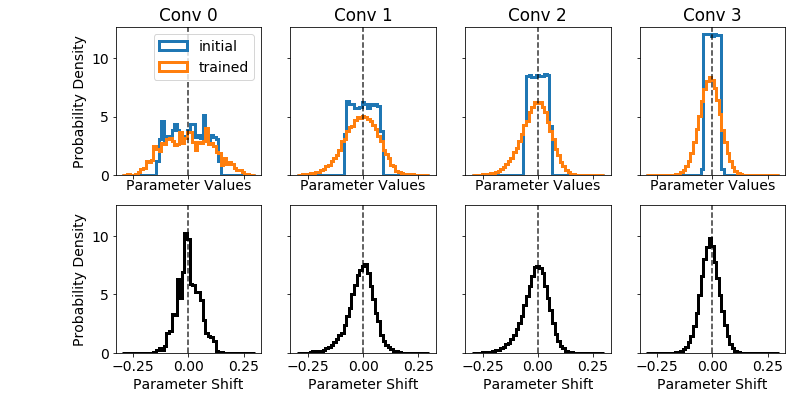

In [64]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True)

for conv_idx in range(len(conv_kernels)):
    k0_initial = restack_kernel(initial_conv_kernels[conv_idx], separator_width=0)
    k0_trained = restack_kernel(conv_kernels[conv_idx], separator_width=0)
    
    resids = k0_trained-k0_initial
    
    trained_rms = np.std(k0_trained)
    resid_rms = np.std(resids)
    
    hist_kwargs = dict(bins=51, range=(-0.3, 0.3), normed=True, histtype="step", lw=3)
    axes[0, conv_idx].hist(k0_initial.ravel(), label="initial", **hist_kwargs)
    axes[0, conv_idx].hist(k0_trained.ravel(), label="trained", **hist_kwargs)
    axes[1, conv_idx].hist(resids.ravel(), color="k", **hist_kwargs)
    
    axes[0, conv_idx].set_title("Conv {}".format(conv_idx))

    axes[0, conv_idx].set_xlabel("Parameter Values")
    axes[1, conv_idx].set_xlabel("Parameter Shift")
    axes[1, conv_idx].annotate(
        "$\sigma_{r}/\sigma$\n" + "{:3.3f}".format(resid_rms/trained_rms), 
        xy=(-0.4, 9), 
        fontsize=18,
    )

axes[0, 0].legend(loc="best")
axes[0, 0].set_ylabel("Probability Density")
axes[1, 0].set_ylabel("Probability Density")
    
for ax in axes.ravel():
    ax.axvline(0.0, c="k", alpha=0.8, linestyle="--")


As you can see, the residuals between the initial parameters and the final trained parameters is much better than random (since the residual distribution is narrower than the trained parameter value distribution itself). 

The effect is only really strong for the input layer and becomes progressively weaker as we move to deeper layers but persists never the less. We can also see that there is a noticeable shift towards negative values in the trained parameters, something you might also have gleaned from the dominance of blue in the stacked heatmap visualizations above.

# Going Deeper

The stacked heatmap visualization we worked with here is somewhat useful (and pretty) as it stands. But there will be little to no consistency between visualizations of different networks, or even the same network trained with different initializations. In order to have any hope of making the visualizations truly meaningful we need somehow to incorporate some sort of standardizing context. 

My first impulse is to apply PCA to the activations being input into each convolution layer and to then project the kernels onto the principal vectors. However as I started to implement that idea I realized that the non-linearity introduced by the relu activation function severely limits the accuracy of a PCA expansion of the activations. Accounting for this complication and doing a really proper job of modeling the activation model activation distribution is a deep enough rabbit hole that it makes sense to break it out into its own blog post or perhaps even a series of posts.

Even with a good activation distributional model in hand the challenge of meaningfully organizing the input/output channel information remains a fundamentally tough problem. The good news is that once we have a distributional model over patches of input activations then we can collapse the first three dimensions of the kernel against artfully chosen samples from the activation distribution which will turn the complex and unfamiliar problem of considering a 4D convolution kernel into the much more familiar problem of considering a linear transform matrix $x_2=x_1 W + b$. This has the additional benefit that we can then apply exactly the same techniques to visualize both convolution kernels and dense network kernels. 